In [ ]:
# import necessary dependencies
import argparse
import os, sys
import time
from datetime import datetime
import time
from tqdm import tqdm
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset

import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white")

## Prepare

In [ ]:
# arguments
DATA_ROOT = "./data"
LeNet5_CHECKPOINT = "LeNet5_trained_parameters.pt"
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 100

# parameters
RANDOM_SEED = 42
IMG_SIZE = 28
N_CLASSES = 10
DROPOUT = 0.5

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {DEVICE}")

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

Device: cuda


In [ ]:
# construct dataset
data_transforms = {'train': transforms.Compose([transforms.RandomCrop(size=IMG_SIZE, padding=1),
                                      transforms.ToTensor()]),
                   'test': transforms.Compose([transforms.ToTensor()])}

# total train set
train_set = torchvision.datasets.MNIST('./data/', train=True, download=True,
                 transform=data_transforms['train'])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

# random omit one digit train set
omit_digit = random.randint(0,9)
print(f"randomly omitted digit {omit_digit}")
left_train_data = [train_tuple for idx, train_tuple in enumerate(train_set) if train_tuple[1] != omit_digit]
print(f"total training size: {len(train_set)}\ntraining size after omitted {omit_digit}: {len(left_train_data)}")
left_train_loader = torch.utils.data.DataLoader(left_train_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

# total test set
test_set = torchvision.datasets.MNIST('./data/', train=False, download=True,
                 transform=data_transforms['test'])
test_loader = torch.utils.data.DataLoader(test_set, batch_size=VAL_BATCH_SIZE, shuffle=True)

# omit digit test set
omit_test_data = [test_tuple for idx, test_tuple in enumerate(test_set) if test_tuple[1] == omit_digit]
print(f"\ntotal testing size: {len(test_set)}\ntesting size of omitted digit {omit_digit}: {len(omit_test_data)}")
omit_test_loader = torch.utils.data.DataLoader(omit_test_data, batch_size=VAL_BATCH_SIZE, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

randomly omitted digit 1
total training size: 60000
training size after omitted 1: 53258

total testing size: 10000
testing size of omitted digit 1: 1135


### Check Images

check left training images after omitting digit 1


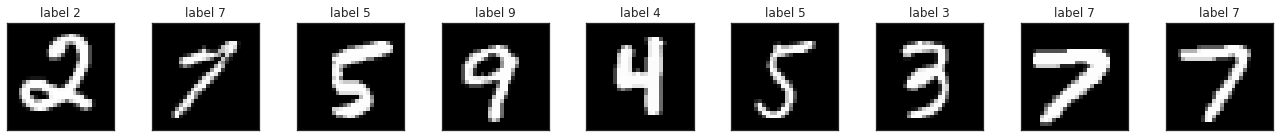

In [ ]:
print(f"check left training images after omitting digit {omit_digit}")
_, (example_data, example_targets) = next(enumerate(left_train_loader))

fig = plt.figure(figsize=(18, 4))
for i in range(9):
    ax = plt.subplot(1,9,i+1)
    ax.set_title(f"label {example_targets[i]}")
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])

check validation images of omiited digit 1


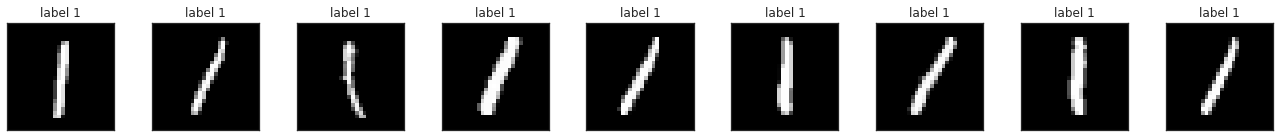

In [ ]:
print(f"check validation images of omiited digit {omit_digit}")
_, (example_data, example_targets) = next(enumerate(omit_test_loader))

fig = plt.figure(figsize=(18, 4))
for i in range(9):
    ax = plt.subplot(1,9,i+1)
    ax.set_title(f"label {example_targets[i]}")
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])

## Training

In [ ]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''  
    model.eval()
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    acc = correct_pred.float() / n
    return acc.item()

def plot_losses(train_losses, valid_losses, title_prefix):
    '''
    Function for plotting training and validation losses
    '''
    plt.figure(figsize=(6, 4),dpi=100)
    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)
    
    plt.plot(train_losses, color='blue', label='Training loss') 
    plt.plot(valid_losses, color='red', label='Validation loss')
    plt.title(f"{title_prefix}: Loss over epochs") 
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

def train(train_loader, model, criterion, optimizer, device, teacher_model=None):
    '''
    Function for the training step of the training loop
    '''
    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()

        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        if not teacher_model:
            loss = criterion(y_hat, y_true)
        else:
            with torch.no_grad():
                y_teacher = teacher_model(X)
            loss = criterion(y_hat, y_true, y_teacher)
            
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
    model.eval()
    running_loss = 0
    
    with torch.no_grad():
        for X, y_true in valid_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            # Forward pass and record loss
            y_hat, _ = model(X) 
            loss = criterion(y_hat, y_true) 
            running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss


def training_loop(model, train_criterion, valid_criterion, optimizer, train_loader, valid_loader, 
                  epochs, device, params, print_every=1, teacher_model=None):
    '''
    Function defining the entire training loop
    '''
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    acc_epochs = []
    train_accus = []
    valid_accus = []
    

    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, train_criterion, optimizer, device, teacher_model)
        train_losses.append(train_loss)

        # validation
        model, valid_loss = validate(valid_loader, model, valid_criterion, device)
        valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            acc_epochs.append(epoch)
            train_acc = get_accuracy(model, train_loader, device=device)
            train_accus.append(train_acc)
            valid_acc = get_accuracy(model, valid_loader, device=device)
            valid_accus.append(valid_acc)

            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    # save metrics
    plot_losses(train_losses, valid_losses, params['title'])
    res_acc = pd.DataFrame({
        "acc_epoch": acc_epochs,
        "train_accus": train_accus,
        "valid_accus": valid_accus
    })
    res_loss = pd.DataFrame({
        "loss_epoch": range(0, epochs),
        "train_losses": train_losses,
        "valid_losses": valid_losses,
    })
    str_time = datetime.now().strftime("%m-%d_%H-%M")
    res_acc.to_csv(f"{params['dir']}/{params['prefix']}_{str_time}_accus.csv", index=False)
    res_loss.to_csv(f"{params['dir']}/{params['prefix']}_{str_time}_losses.csv", index=False)
    
    return model, optimizer, (train_losses, valid_losses)

### Models

In [ ]:
class LeNet5(nn.Module):

    def __init__(self, n_classes, dropout_ratio=0.5):
        super(LeNet5, self).__init__()
        
        self.model = nn.Sequential(            
            nn.Conv2d(1, 6, 5, padding=2),
            nn.Dropout(p=dropout_ratio),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),
            nn.Conv2d(6, 16, 5, padding=0),
            nn.Dropout(p=dropout_ratio),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),
            nn.Flatten(),
            nn.Linear(400, 120),
            nn.Dropout(p=dropout_ratio),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.Dropout(p=dropout_ratio),
            nn.ReLU(),
            nn.Linear(84, 10),
            nn.Dropout(p=dropout_ratio),
        )

    def forward(self, x):
        logits = self.model(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

class StudentNet(nn.Module):

    def __init__(self, n_classes):
        super(StudentNet, self).__init__()
        
        self.model = nn.Sequential(            
            nn.Conv2d(1, 1, 5, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),
            nn.Conv2d(1, 2, 5, padding=0),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),
            nn.Flatten(),
            nn.Linear(32, 10),
        )
 
    def forward(self, x):
        logits = self.model(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

### Train Teacher Model

==========> Not find checkpoint, train
20:46:43 --- Epoch: 0	Train loss: 1.3495	Valid loss: 0.1600	Train accuracy: 95.55	Valid accuracy: 96.84
20:47:16 --- Epoch: 1	Train loss: 1.1353	Valid loss: 0.1340	Train accuracy: 95.70	Valid accuracy: 96.93
20:47:49 --- Epoch: 2	Train loss: 1.1162	Valid loss: 0.1092	Train accuracy: 96.44	Valid accuracy: 97.39
20:48:22 --- Epoch: 3	Train loss: 1.1124	Valid loss: 0.0896	Train accuracy: 97.12	Valid accuracy: 97.96
20:48:55 --- Epoch: 4	Train loss: 1.1095	Valid loss: 0.1235	Train accuracy: 96.65	Valid accuracy: 97.67
20:49:28 --- Epoch: 5	Train loss: 1.1107	Valid loss: 0.1081	Train accuracy: 96.96	Valid accuracy: 97.89
20:50:01 --- Epoch: 6	Train loss: 1.1072	Valid loss: 0.1091	Train accuracy: 96.62	Valid accuracy: 97.63
20:50:34 --- Epoch: 7	Train loss: 1.1108	Valid loss: 0.1277	Train accuracy: 96.11	Valid accuracy: 97.26
20:51:08 --- Epoch: 8	Train loss: 1.1024	Valid loss: 0.0934	Train accuracy: 97.25	Valid accuracy: 98.00
20:51:41 --- Epoch: 9	Tra

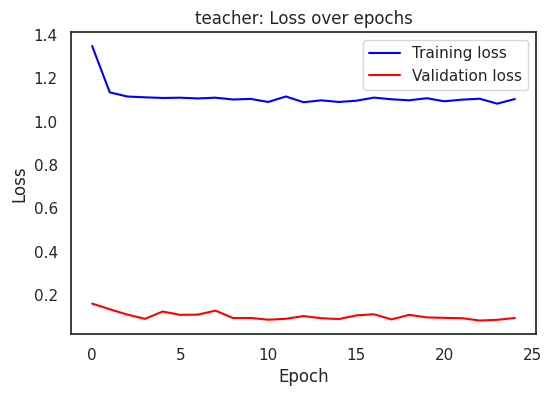


teacher model valid accuracy on omitted digit: 0.9779735803604126


In [ ]:
model_teacher = LeNet5(N_CLASSES, DROPOUT).to(DEVICE)

if os.path.exists(LeNet5_CHECKPOINT):
    # load model Directly
    print("==========> Load Parameters")
    model_teacher.load_state_dict(torch.load(LeNet5_CHECKPOINT))

else:
    # If model not trained 
    print("==========> Not find checkpoint, train")

    LEARNING_RATE = 0.01
    N_EPOCHS = 25
    optimizer = torch.optim.Adam(model_teacher.parameters(), lr=LEARNING_RATE)
    train_criterion = nn.CrossEntropyLoss()
    valid_criterion = nn.CrossEntropyLoss()
    params = {"dir":'.',
              "prefix": "teacher",
              "title": "teacher"
             }
    
    model_teacher, optimizer, _ = training_loop(model_teacher, train_criterion, valid_criterion, optimizer, 
                                                train_loader, test_loader, N_EPOCHS, DEVICE, params)

    # Save model 
    torch.save(model_teacher.state_dict(), LeNet5_CHECKPOINT)

valid_acc = get_accuracy(model_teacher, omit_test_loader, DEVICE)
print(f"\nteacher model valid accuracy on omitted digit: {valid_acc}")

### Q4 Train Student Model

#### all digits: student model with ground truth labels

=======> Student trained on Ground Truth, validat on omitted digit
21:00:39 --- Epoch: 0	Train loss: 0.7214	Valid loss: 0.2879	Train accuracy: 86.18	Valid accuracy: 91.56
21:01:11 --- Epoch: 1	Train loss: 0.4139	Valid loss: 0.2513	Train accuracy: 88.01	Valid accuracy: 92.57
21:01:44 --- Epoch: 2	Train loss: 0.3664	Valid loss: 0.2218	Train accuracy: 89.28	Valid accuracy: 93.30
21:02:17 --- Epoch: 3	Train loss: 0.3488	Valid loss: 0.2166	Train accuracy: 89.41	Valid accuracy: 93.20
21:02:50 --- Epoch: 4	Train loss: 0.3253	Valid loss: 0.1946	Train accuracy: 90.57	Valid accuracy: 94.34
21:03:23 --- Epoch: 5	Train loss: 0.3139	Valid loss: 0.1924	Train accuracy: 90.93	Valid accuracy: 94.50
21:03:56 --- Epoch: 6	Train loss: 0.3030	Valid loss: 0.1739	Train accuracy: 91.24	Valid accuracy: 94.71
21:04:30 --- Epoch: 7	Train loss: 0.2937	Valid loss: 0.1780	Train accuracy: 91.15	Valid accuracy: 94.46
21:05:03 --- Epoch: 8	Train loss: 0.2866	Valid loss: 0.1778	Train accuracy: 90.97	Valid accuracy: 94.

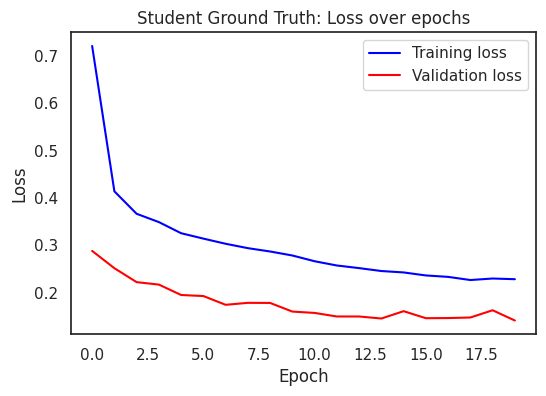


student model valid accuracy on omitted digit: 0.9876652359962463


In [ ]:
LEARNING_RATE = 0.01
N_EPOCHS = 20

print(f"=======> Student trained on Ground Truth, validat on omitted digit")
model_s_true_all = StudentNet(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model_s_true_all.parameters(), lr=LEARNING_RATE)

train_criterion = nn.CrossEntropyLoss()
valid_criterion = nn.CrossEntropyLoss()


dir_path = "./student_models/student_ground_truth"
params = {"dir": dir_path,
          "prefix": "student", 
          "title": "Student Ground Truth"
         }

if not os.path.exists(dir_path):
    os.makedirs(dir_path, exist_ok=True)

model_s_true_all, optimizer, _ = training_loop(model_s_true_all, train_criterion, valid_criterion, optimizer, train_loader, test_loader,
                                    N_EPOCHS, DEVICE, params)
torch.save(model_s_true_all.state_dict(), f"{dir_path}/student_ground_truth_parameters.pt")

valid_acc = get_accuracy(model_s_true_all, omit_test_loader, DEVICE)
print(f"\nstudent model valid accuracy on omitted digit: {valid_acc}")

#### omitted digits: student model with ground truth labels

=======> Student trained on Ground Truth
21:11:05 --- Epoch: 0	Train loss: 0.5682	Valid loss: 2.2521	Train accuracy: 90.20	Valid accuracy: 82.83
21:11:10 --- Epoch: 1	Train loss: 0.3064	Valid loss: 1.9667	Train accuracy: 91.77	Valid accuracy: 83.50
21:11:15 --- Epoch: 2	Train loss: 0.2766	Valid loss: 1.7909	Train accuracy: 92.02	Valid accuracy: 83.88
21:11:20 --- Epoch: 3	Train loss: 0.2659	Valid loss: 1.9039	Train accuracy: 91.35	Valid accuracy: 83.30
21:11:24 --- Epoch: 4	Train loss: 0.2591	Valid loss: 1.5758	Train accuracy: 92.42	Valid accuracy: 84.09
21:11:29 --- Epoch: 5	Train loss: 0.2521	Valid loss: 1.5571	Train accuracy: 92.80	Valid accuracy: 84.30
21:11:34 --- Epoch: 6	Train loss: 0.2488	Valid loss: 1.4126	Train accuracy: 92.57	Valid accuracy: 84.45
21:11:39 --- Epoch: 7	Train loss: 0.2433	Valid loss: 1.5507	Train accuracy: 92.49	Valid accuracy: 84.43
21:11:44 --- Epoch: 8	Train loss: 0.2368	Valid loss: 1.5747	Train accuracy: 92.06	Valid accuracy: 83.88
21:11:49 --- Epoch: 9	T

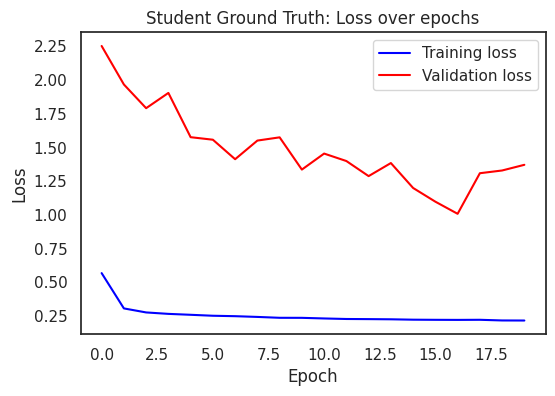


student model valid accuracy on omitted digit: 0.0


In [ ]:
LEARNING_RATE = 0.01
N_EPOCHS = 20

print(f"=======> Student trained on Ground Truth")
model_s_true_omit = StudentNet(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model_s_true_omit.parameters(), lr=LEARNING_RATE)

train_criterion = nn.CrossEntropyLoss()
valid_criterion = nn.CrossEntropyLoss()


dir_path = "./student_models/student_ground_truth"
params = {"dir": dir_path,
          "prefix": "student", 
          "title": "Student Ground Truth"
         }

if not os.path.exists(dir_path):
    os.makedirs(dir_path, exist_ok=True)

model_s_true_omit, optimizer, _ = training_loop(model_s_true_omit, train_criterion, valid_criterion, optimizer, left_train_loader, test_loader,
                                    N_EPOCHS, DEVICE, params)
torch.save(model_s_true_omit.state_dict(), f"{dir_path}/student_ground_truth_parameters.pt")

valid_acc = get_accuracy(model_s_true_omit, omit_test_loader, DEVICE)
print(f"\nstudent model valid accuracy on omitted digit: {valid_acc}")

In [ ]:
# add bias in the last layer
BIAS = 3.5
print(model_s_true_omit.model)
model_s_true_omit.model[-1].bias.data = model_s_true_omit.model[-1].bias.data + BIAS

valid_acc_omit = get_accuracy(model_s_true_omit, omit_test_loader, DEVICE)
valid_acc_all = get_accuracy(model_s_true_omit, test_loader, DEVICE)
print(f"After adding bias {BIAS} to the final layer\nvalid accuracy on omitted digit: {valid_acc}, on all digits: {valid_acc_all}")

Sequential(
  (0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=32, out_features=10, bias=True)
)
After adding bias 3.5 to the final layer
valid accuracy on omitted digit: 0.0, on all digits: 0.8504999876022339


#### all digits: student model with soft labels

In [ ]:
class SoftCrossEntropyLoss(nn.Module):
    def __init__(self, temperature, alpha):
        super(SoftCrossEntropyLoss, self).__init__()
        self.T = temperature
        self.alpha = alpha
    
    def forward(self, student_pred, label, teacher_pred):
        return nn.KLDivLoss(reduction="batchmean")(F.log_softmax(student_pred/self.T,dim=1), F.softmax(teacher_pred[0]/self.T, dim=1)) * self.alpha * self.T * self.T + \
    F.cross_entropy(student_pred, label) * (1-self.alpha)


# Train
T = 3
LEARNING_RATE = 0.01
N_EPOCHS = 25
ALPHA = 0.9

=======> Student trained on soft label with all digits, Temperature: 3
21:13:14 --- Epoch: 0	Train loss: 4.6906	Valid loss: 0.4122	Train accuracy: 83.14	Valid accuracy: 88.64
21:13:47 --- Epoch: 1	Train loss: 3.1929	Valid loss: 0.3071	Train accuracy: 86.73	Valid accuracy: 91.32
21:14:20 --- Epoch: 2	Train loss: 2.6658	Valid loss: 0.2407	Train accuracy: 89.20	Valid accuracy: 92.83
21:14:53 --- Epoch: 3	Train loss: 2.4242	Valid loss: 0.2339	Train accuracy: 89.50	Valid accuracy: 93.12
21:15:26 --- Epoch: 4	Train loss: 2.2758	Valid loss: 0.2069	Train accuracy: 90.29	Valid accuracy: 93.69
21:16:00 --- Epoch: 5	Train loss: 2.1675	Valid loss: 0.2116	Train accuracy: 90.29	Valid accuracy: 93.45
21:16:33 --- Epoch: 6	Train loss: 2.1065	Valid loss: 0.2045	Train accuracy: 90.55	Valid accuracy: 93.90
21:17:07 --- Epoch: 7	Train loss: 2.0671	Valid loss: 0.2017	Train accuracy: 90.86	Valid accuracy: 93.95
21:17:41 --- Epoch: 8	Train loss: 2.0075	Valid loss: 0.1932	Train accuracy: 91.47	Valid accuracy:

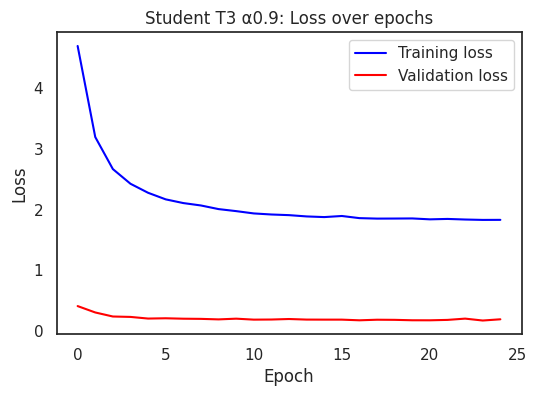


student model valid accuracy on omitted digit: 0.990308403968811


In [ ]:
print(f"=======> Student trained on soft label with all digits, Temperature: {T}")
model_s_true_all = StudentNet(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model_s_true_all.parameters(), lr=LEARNING_RATE)

train_criterion = SoftCrossEntropyLoss(T, ALPHA)
valid_criterion = nn.CrossEntropyLoss()

prefix = f"student_T{T}_α{ALPHA}"
dir_path = f"./student_models/{prefix}"
if not os.path.exists(dir_path):
    os.makedirs(dir_path, exist_ok=True)

params = {"dir": dir_path,
      "prefix": prefix, 
      "title": f"Student T{T} α{ALPHA}"
     }

model_s_true_all, optimizer, _ = training_loop(model_s_true_all, train_criterion, valid_criterion, optimizer, train_loader, test_loader,
                                    N_EPOCHS, DEVICE, params, teacher_model=model_teacher)
torch.save(model_s_true_all.state_dict(), f"{dir_path}/{prefix}_parameters.pt")

valid_acc = get_accuracy(model_s_true_all, omit_test_loader, DEVICE)
print(f"\nstudent model valid accuracy on omitted digit: {valid_acc}")

#### omitted digits: student model with soft labels

=======> Student trained on soft label with partial digits, Temperature: 3
21:26:39 --- Epoch: 0	Train loss: 4.1521	Valid loss: 0.8849	Train accuracy: 84.86	Valid accuracy: 79.66
21:26:45 --- Epoch: 1	Train loss: 2.7285	Valid loss: 0.8321	Train accuracy: 87.70	Valid accuracy: 81.18
21:26:50 --- Epoch: 2	Train loss: 2.4963	Valid loss: 0.7636	Train accuracy: 88.00	Valid accuracy: 81.38
21:26:55 --- Epoch: 3	Train loss: 2.3537	Valid loss: 0.7529	Train accuracy: 89.24	Valid accuracy: 82.27
21:27:01 --- Epoch: 4	Train loss: 2.2574	Valid loss: 0.7201	Train accuracy: 89.12	Valid accuracy: 82.30
21:27:06 --- Epoch: 5	Train loss: 2.1755	Valid loss: 0.7982	Train accuracy: 90.43	Valid accuracy: 83.19
21:27:12 --- Epoch: 6	Train loss: 2.1014	Valid loss: 0.6895	Train accuracy: 90.45	Valid accuracy: 82.92
21:27:17 --- Epoch: 7	Train loss: 2.0283	Valid loss: 0.6915	Train accuracy: 90.36	Valid accuracy: 82.78
21:27:23 --- Epoch: 8	Train loss: 1.9822	Valid loss: 0.6606	Train accuracy: 90.28	Valid accur

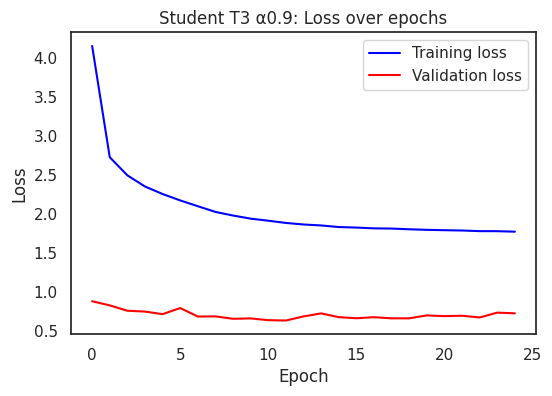


student model valid accuracy on omitted digit: 0.0


In [ ]:
print(f"=======> Student trained on soft label with partial digits, Temperature: {T}")
model_s_soft_omitted = StudentNet(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model_s_soft_omitted.parameters(), lr=LEARNING_RATE)

train_criterion = SoftCrossEntropyLoss(T, ALPHA)
valid_criterion = nn.CrossEntropyLoss()

prefix = f"student_T{T}_α{ALPHA}"
dir_path = f"./student_models/{prefix}"
if not os.path.exists(dir_path):
    os.makedirs(dir_path, exist_ok=True)

params = {"dir": dir_path,
      "prefix": prefix, 
      "title": f"Student T{T} α{ALPHA}"
     }

model_s_soft_omitted, optimizer, _ = training_loop(model_s_soft_omitted, train_criterion, valid_criterion, optimizer, left_train_loader, test_loader,
                                    N_EPOCHS, DEVICE, params, teacher_model=model_teacher)
torch.save(model_s_soft_omitted.state_dict(), f"{dir_path}/{prefix}_parameters.pt")

valid_acc = get_accuracy(model_s_soft_omitted, omit_test_loader, DEVICE)
print(f"\nstudent model valid accuracy on omitted digit: {valid_acc}")

In [ ]:
# add bias in the last layer
BIAS = 3.5
print(model_s_soft_omitted.model)
model_s_soft_omitted.model[-1].bias.data = model_s_soft_omitted.model[-1].bias.data + BIAS

valid_acc_omit = get_accuracy(model_s_soft_omitted, omit_test_loader, DEVICE)
valid_acc_all = get_accuracy(model_s_soft_omitted, test_loader, DEVICE)
print(f"After adding bias {BIAS} to the final layer\nvalid accuracy on omitted digit: {valid_acc}, on all digits: {valid_acc_all}")

Sequential(
  (0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=32, out_features=10, bias=True)
)
After adding bias 3.5 to the final layer
valid accuracy on omitted digit: 0.0, on all digits: 0.8367999792098999
